<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install -U pywsd

     |████████████████████████████████| 26.9 MB 116 kB/s eta 0:00:01          | 12.2 MB 1.1 MB/s eta 0:00:14
     |████████████████████████████████| 31.6 MB 93 kB/s  eta 0:00:01     |████████████████████▊           | 20.5 MB 1.1 MB/s eta 0:00:11
  Created wheel for wn: filename=wn-0.0.23-py3-none-any.whl size=31792943 sha256=d97c235913005b025fcdf8b59f9050396b40330fc1b20389bb8d436196f95906
  Stored in directory: /home/jovyan/.cache/pip/wheels/cd/8b/7d/c44f094ca392bd08edcd90adf241a3484b75e2b8e205fab50a
Successfully built wn


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from scipy.sparse import vstack

In [5]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('C://Users//web//Desktop//Новая папка (6)//toxic_comments.csv')

In [7]:
df.sample(10)

,Unnamed: 0,text,toxic
97474,97568,"""\n That would be, for me, like debating a cre...",0
119064,119169,wikipedia admins clearly abuse their power by ...,0
86668,86749,"""\n\n Kommilitonen! \n\nHi. How about """"fello...",0
152534,152691,"That helps! Oh, trust me, i'm never vandalizin...",0
117322,117421,"""\n\nThe number one rule of Wikipedia, as show...",0
138353,138504,I did NOT attack you personally. I did NOT vi...,0
104256,104353,Your edit to Mikoyan MiG-31\nWikipedia is not ...,0
96969,97062,Don \n\nNews to me. I'll file it for future u...,0
124889,125018,Reporting you\nI now reporting you. Despite be...,0
49870,49925,"""\nFWIW, I think all the """"References"""" in the...",0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [9]:
df.duplicated().sum()

0

**Балланс классов**

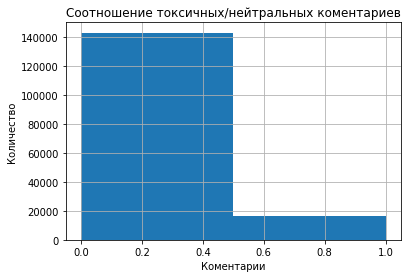

In [10]:
df['toxic'].hist(bins=2)
plt.title('Соотношение токсичных/нейтральных коментариев')
plt.xlabel('Коментарии')
plt.ylabel('Количество')
plt.show()

In [11]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
df[df['toxic'] == 1]['toxic'].count() / df[df['toxic'] == 0]['toxic'].count()

0.11310497114027364

**Длина коментария**

In [13]:
pd.DataFrame(data=[[df[df['toxic'] == 1]['text'].apply(len).mean(), df[df['toxic'] == 0]['text'].apply(len).mean()],
                   [df[df['toxic'] == 1]['text'].apply(len).median(), df[df['toxic'] == 0]['text'].apply(len).median()]],
             index=['средняя длинна','медианная длинна'],
             columns=['Токсичный','Не токсичный']
            )

,Токсичный,Не токсичный
средняя длинна,302.932411,403.956585
медианная длинна,128.000000,216.000000


Посмотрим какие слова чаще всего встречаются в коментариях

In [14]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)
# Lemmatizing
features = df['text'].apply(lambda x: lemmatize_sentence(x))
features

0         Explanation Why the edits make under my userna...
1         D'aww ! He match this background colour I 'm s...
2         Hey man , I 'm really not try to edit war . It...
3         `` More I ca n't make any real suggestion on i...
4         You , sir , be my hero . Any chance you rememb...
                                ...                        
159287    `` : : : : : And for the second time of ask , ...
159288    You should be ashamed of yourself That be a ho...
159289    Spitzer Umm , theres no actual article for pro...
159290    And it look like it be actually you who put on...
159291    `` And ... I really do n't think you understan...
Name: text, Length: 159292, dtype: object

Разделим набор данных на выборки

- Тренировачную

- Валидационную

- Тестовую

In [16]:
%%time
# Создаём выборки

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              df['toxic'], 
                                                                              test_size=0.2, 
                                                                              random_state=123)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5, 
                                                                            random_state=123)
# Векторизация текста
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000)

features_train_vect = vectorizer.fit_transform(features_train)
features_valid_vect = vectorizer.transform(features_valid)
features_test_vect = vectorizer.transform(features_test)

CPU times: user 40.2 s, sys: 1.03 s, total: 41.2 s
Wall time: 41.4 s


### Вывод

- Данные загружены и изучены

- В столбце **text** указан сам коментарий,а в столбце **toxic** обозначено токсичный он или нет

- Токсичных коментариев в 10 раз больше чем нетоксичных

- Длина токсичного комента на 1/3 меньше чем не ткосичного

- Составлены облака слов токсичных и нейтралтных коментариев

- Выборки подготовлены

## Обучение

Рассмотрим 2 варианта решений

- Логистическая регрессия

- Дерево решений

(Пробовал обучить на  BERT но эмбендинги показали мне 13 часов- отказался от этого варианта)

Так же чт обы не дублировать код напишем 2 функции для подсчета ф1 метркии

In [17]:
def get_f1_valid(model, X, y, X_test, y_test):
    model.fit(X, y)
    predictions = model.predict(X_test)
     
    return round(f1_score(y_test, predictions), 3)

In [18]:
def get_f1_cv(model, 
              parametrs, 
              X=vstack((features_train_vect, features_valid_vect)), 
              y=pd.concat([target_train, target_valid])):
    validation_set_indexes = [-1]*features_train_vect.shape[0] + [0]*features_valid_vect.shape[0]
    ps = PredefinedSplit(test_fold=validation_set_indexes)
    
    rs = RandomizedSearchCV(model, 
                            parametrs, 
                            scoring='f1', 
                            cv=ps,
                            random_state = 123,
                            n_jobs=-1
                           )
    rs.fit(X, y)
    
    return round(rs.best_score_, 3), rs.best_params_

**Логистическая регрессия**

In [19]:
%%time
get_f1_valid(LogisticRegression(max_iter=2000, random_state=123), 
             X=features_train_vect, 
             y=target_train, 
             X_test=features_valid_vect, 
             y_test=target_valid
            )

CPU times: user 26.9 s, sys: 45.8 s, total: 1min 12s
Wall time: 1min 17s


0.735

In [20]:
%%time
# Кэф регурялизации
get_f1_cv(LogisticRegression(max_iter=2000, random_state=123),
          {'C':[2,3,4,5,7,10,15,20,40,50]}
         )

CPU times: user 9min 14s, sys: 14min 56s, total: 24min 10s
Wall time: 31min 51s


(0.78, {'C': 15})

In [18]:
%%time
# С гипппер параметрами
get_f1_valid(LogisticRegression(max_iter=2000, C=10, random_state=123), 
             X=features_train_vect, 
             y=target_train, 
             X_test=features_valid_vect, 
             y_test=target_valid
            )

CPU times: user 1min 5s, sys: 1min 10s, total: 2min 15s
Wall time: 2min 16s


0.779

Логистическая регрессия с регурялизацией решает задачу

**Дерево решений**

In [19]:
%%time
get_f1_valid(DecisionTreeClassifier(max_depth=30, random_state=123), 
             X=features_train_vect, 
             y=target_train, 
             X_test=features_valid_vect, 
             y_test=target_valid
            )

CPU times: user 41.2 s, sys: 49 ms, total: 41.3 s
Wall time: 41.3 s


0.666

In [ ]:
%%time
# Подбор глубина 
get_f1_cv(DecisionTreeClassifier(random_state=123),
          {'max_depth': range(2,50)}
         )

In [ ]:
%%time
# Модель с подобранными гиперпараметрами
get_f1_valid(DecisionTreeClassifier(max_depth=42, random_state=123), 
             X=features_train_vect, 
             y=target_train, 
             X_test=features_valid_vect, 
             y_test=target_valid
            )

Решающее дерево не решает нашу задачу

### Тестирование

In [ ]:
%%time
get_f1_valid(LogisticRegression(max_iter=2000, C=10, random_state=123),
             X=vstack((features_train_vect, features_valid_vect)), 
             y=pd.concat([target_train, target_valid]),
             X_test=features_test_vect,
             y_test=target_test
            )

Проверка работаспособностьв  сравнении с консстантной моделью

In [ ]:
%%time
get_f1_valid(DummyClassifier(strategy='most_frequent'),
             X=vstack((features_train_vect, features_valid_vect)), 
             y=pd.concat([target_train, target_valid]),
             X_test=features_test_vect,
             y_test=target_test
            )

## Выводы

И так  исходя из проекта можно сделать выводы

В пункте подготовки данных было выполнено 

- Данные загружены и изучены

- В столбце **text** указан сам коментарий,а в столбце **toxic** обозначено токсичный он или нет

- Токсичных коментариев в 10 раз больше чем нетоксичных

- Длина токсичного комента на 1/3 меньше чем не ткосичного

- Составлены облака слов токсичных и нейтралтных коментариев

- Выборки подготовлены

В Пункте обучение было выполенено и иследовано

 Рассмотрены 2 варианта
 
 - Логистическа регрессия 
 
 - Дерево решений
 
 Логистическая регрессия показала такое же качество модели как и на тренировачной выборки,констаная модель не стоит и близко к нашей. На качество работы нашей модели повлияли не только подобраннные гиперпараметры самой модели, но и подготовка данных.
 
 Векторизация TF-IDF (Логистическая регрессия с кэф с=10) успешно справилась с нашим заданием
 
 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны